# Project: Determine Classifier strengths

### Instructions: <br>
- Look at multiple real (as in "not simulated") classification data sets and apply 2-3 classifiers. <br> 
- For each method, find at least one dataset where the chosen method is best (e.g. by performing cross-validation) <br>and the other two methods do not perform as well. <br> There is an extensive list of websites where you can find datasets on the course PM.<br>
-  Explain why the respective classifier is best by inspecting the features <br> e.g. through suitable plots<br>
-  Make sure to properly take care of e.g. stratification if predictors or classes are unbalanced.<br>

In [53]:
import numpy as np
from sklearn import datasets, neighbors, preprocessing, utils, metrics, linear_model, tree, discriminant_analysis
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import random
%matplotlib inline

In [54]:
class Dataset:
    """
    Class: Dataset
    choose from the datasets: iris, digits, breast cancer, wine
    """
    
    def __init__(self, dataset): 
        self.X = None
        self.t = None
        self.dataset = dataset
        self.X_folds = []
        self.t_folds = [] 
        self.target_names = None
        
    def import_dataset(self):
        if self.dataset =='iris':
            data = datasets.load_iris()
        if self.dataset == 'digits':
            data = datasets.load_digits()
        if self.dataset == 'breast_cancer':
            data = datasets.load_breast_cancer()     
        if self.dataset == 'wine':
            data = datasets.load_wine()
       
        self.X = data['data']
        self.t = data['target']
        self.target_names = data['target_names']

    def standardise_data(self):
        standard_scaled = preprocessing.StandardScaler()
        self.X = standard_scaled.fit_transform(self.X)

    def shuffle_data(self):
        self.X, self.t = utils.shuffle(self.X,self.t)
    
    def split_data(self, n_fold):
        self.X_folds = []
        self.t_folds = []
        size_data = len(self.t)
        size_fold = int(size_data/n_fold)
        
        if size_data%n_fold == 0:
            start_index = 0
            stop_index = size_fold 
            for i in range(n_fold):
                self.X_folds.append(self.X[start_index:stop_index])
                self.t_folds.append(self.t[start_index:stop_index])
                
                start_index += size_fold
                stop_index += size_fold
        else:
            remainder = size_data%n_fold
            start_index = 0
            stop_index = size_fold + 1
            remainder -= 1
            
            for i in range(n_fold):
                self.X_folds.append(self.X[start_index:stop_index])
                self.t_folds.append(self.t[start_index:stop_index])
                
                if remainder == 0:
                    start_index = stop_index 
                    stop_index += size_fold
                
                else: 
                    start_index = stop_index 
                    stop_index += size_fold + 1
                    remainder -= 1  

In [55]:
def run_classifier(data, classification_method, n_folds, standardise=True, k_neighbours=6, confusion=False):
    """
    Script that creates the dataset class and runs the classification method using cross validation.
    """
    random.seed(1) 
    
    # Import and prepare dataset
    dataset = Dataset(data)
    dataset.import_dataset()
    if standardise == True:
        dataset.standardise_data()
    
    dataset.shuffle_data()
    dataset.split_data(n_folds)
    n_targets = [np.sum(dataset.t==list(set(dataset.t))[i]) for i in set(dataset.t)]
    
    #print('Number of datapoint for each class:', n_targets)
    
    #print(f'dataset:{data}, size dataset: {len(dataset.t)}, n features:{len(dataset.X[0])}, n_classes:{len(dataset.target_names)}')
    accuracy_score = []
    test_data_index = 0
    
    #iterate throuhg the folds
    for i in range(n_folds): 
        X_test = dataset.X_folds[test_data_index]
        t_test = dataset.t_folds[test_data_index]

        X_train = np.concatenate(np.delete(dataset.X_folds, test_data_index, 0))
        t_train = np.concatenate(np.delete(dataset.t_folds, test_data_index, 0))
        
        # Create classifier
        if classification_method == 'knn':
            classifier = neighbors.KNeighborsClassifier(k_neighbours)
        if classification_method == 'logistic regression':
            classifier = linear_model.LogisticRegression()
        if classification_method == 'decision tree':
            classifier = tree.DecisionTreeClassifier()
        if classification_method=="discriminant analysis":
            classifier = discriminant_analysis.LinearDiscriminantAnalysis()
        
        # Train and predict
        classifier.fit(X_train, t_train)
        Z = classifier.predict(X_test)
        
        accuracy = metrics.accuracy_score(t_test, Z)
        accuracy_score.append(accuracy)
        test_data_index += 1
        
        if i == 0:
            total_confusion_matrix = metrics.confusion_matrix(t_test, Z, normalize='true')*(1/n_folds)
        else:
            this_confusion_matrix = metrics.confusion_matrix(t_test, Z, normalize='true')*(1/n_folds)
            total_confusion_matrix += this_confusion_matrix
        
    average_test_accuracy = np.sum(accuracy_score)/len(accuracy_score)

    print('classifier: ', classification_method, ', dataset: ', data, ', accuracy: ', average_test_accuracy)
    
    if confusion == True:
        # Plot the confusion matrix
        fig, ax = plt.subplots(figsize=(8,8))
        plt.rcParams.update({'font.size': 12})
        im = ax.imshow(total_confusion_matrix, cmap='PuRd')

        ax.set_xticks(np.arange(len(dataset.target_names)))
        ax.set_yticks(np.arange(len(dataset.target_names)))

        ax.set_xticklabels(dataset.target_names)
        ax.set_yticklabels(dataset.target_names)

        for i in range(len(dataset.target_names)):
            for j in range(len(dataset.target_names)):
                text = ax.text(j, i, np.round(total_confusion_matrix[i][j],3),
                               ha="center", va="center", color="black")

        ax.set_title(f"Confusion matrix for: {classification_method} classification of dataset {data} \n \
                        Mean accuracy: {average_test_accuracy}")
        ax.set_xlabel('Predicted outcome')
        ax.set_ylabel('Observed outcome')
        fig.tight_layout()
        plt.show()

    return classifier, accuracy_score

classifier:  knn , dataset:  iris , accuracy:  0.9666666666666668


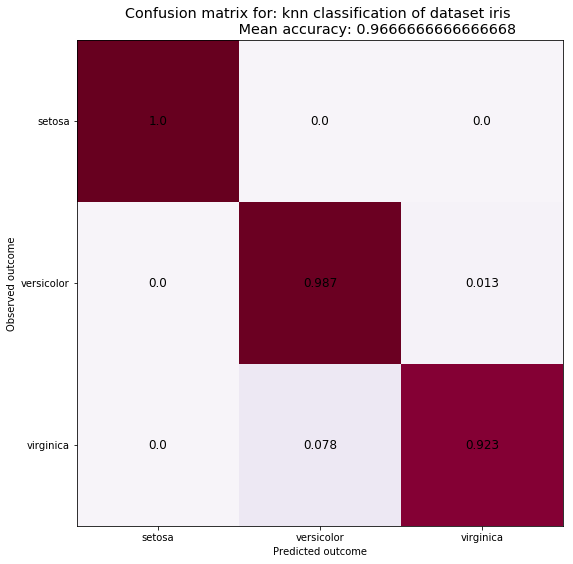

classifier:  logistic regression , dataset:  iris , accuracy:  0.9533333333333334


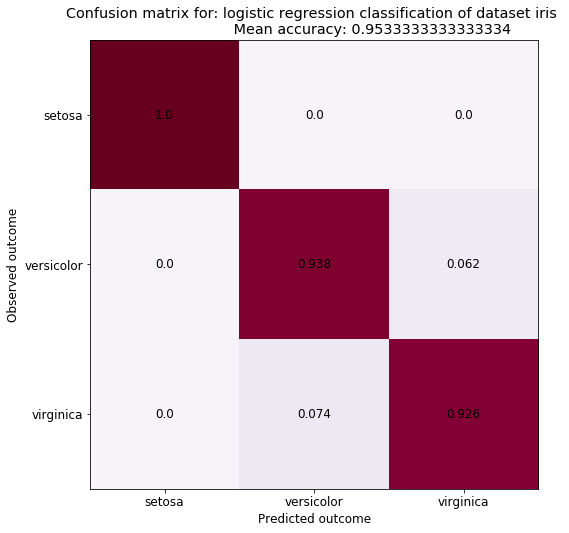

classifier:  decision tree , dataset:  iris , accuracy:  0.9600000000000002


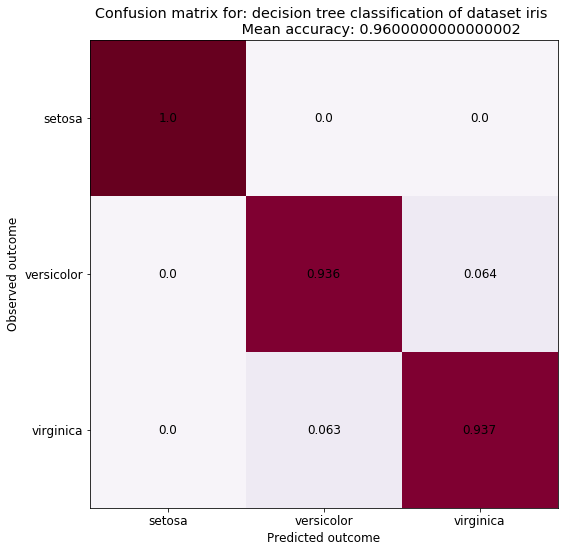

classifier:  discriminant analysis , dataset:  iris , accuracy:  0.9800000000000001


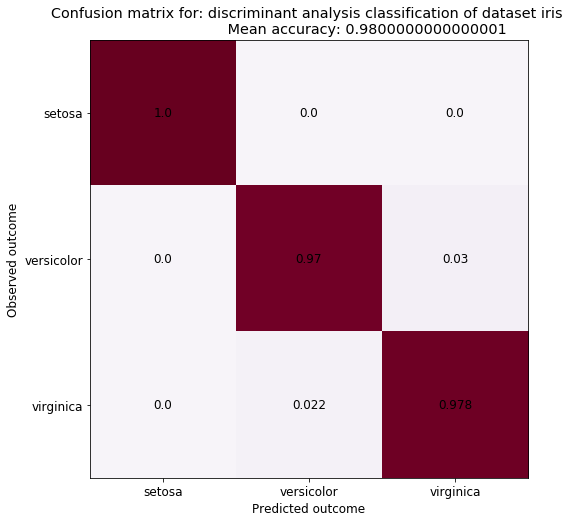

classifier:  knn , dataset:  digits , accuracy:  0.9749566697616837


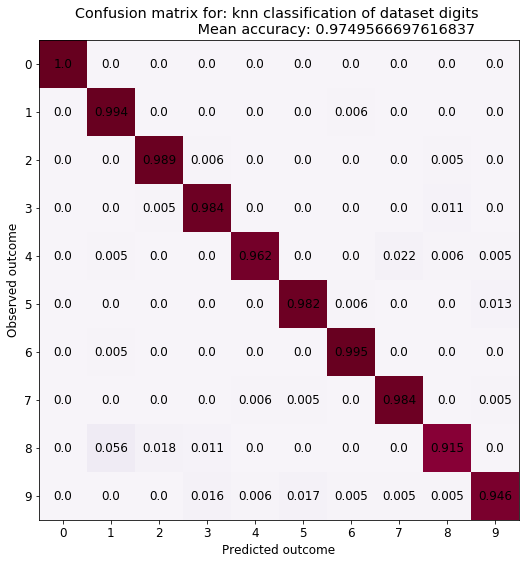

classifier:  logistic regression , dataset:  digits , accuracy:  0.9699504797276385


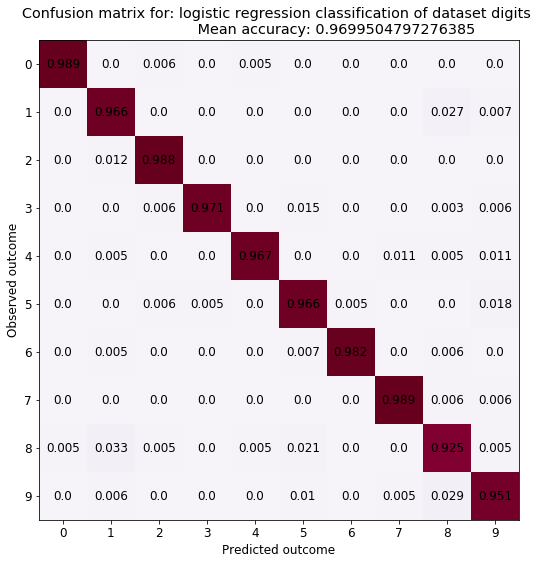

classifier:  decision tree , dataset:  digits , accuracy:  0.8553187867533272


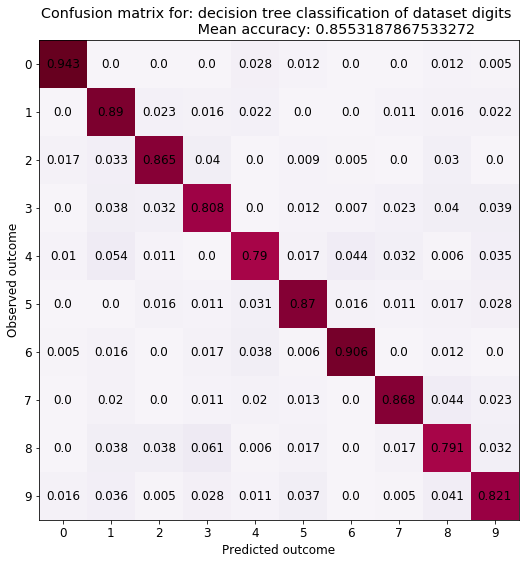

classifier:  discriminant analysis , dataset:  digits , accuracy:  0.9493515939337666


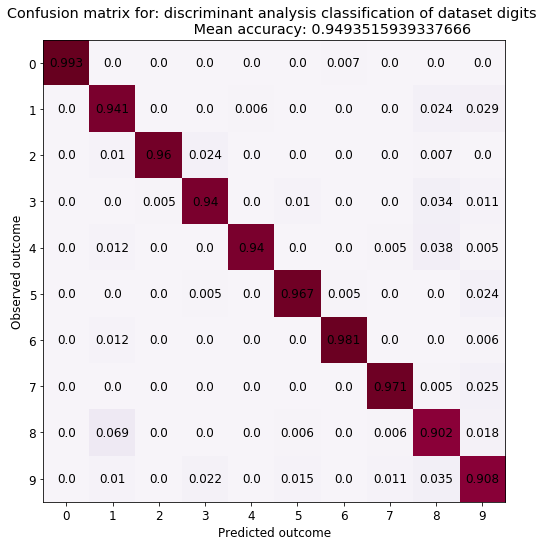

classifier:  knn , dataset:  wine , accuracy:  0.9606349206349206


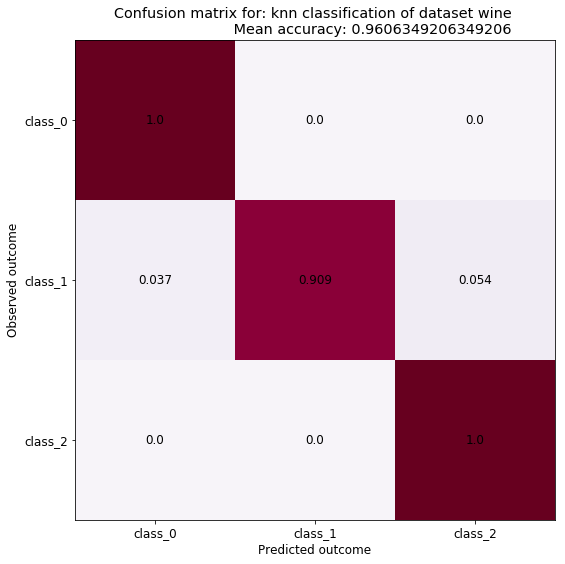

classifier:  logistic regression , dataset:  wine , accuracy:  0.9776190476190475


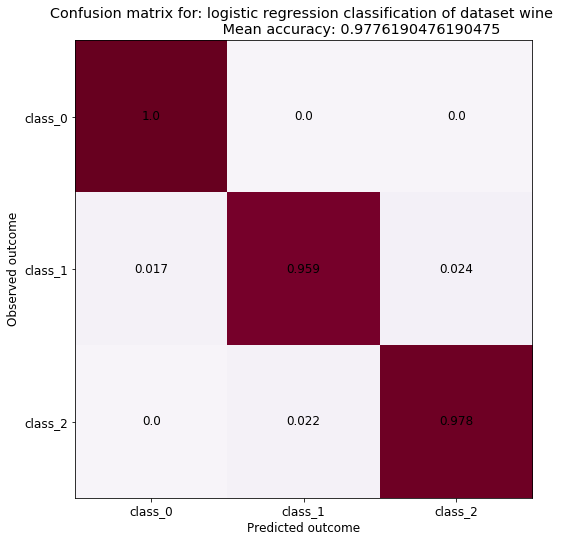

classifier:  decision tree , dataset:  wine , accuracy:  0.9214285714285714


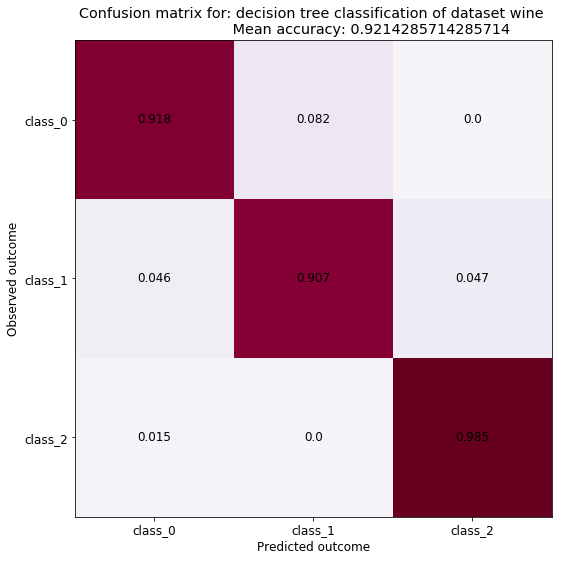

classifier:  discriminant analysis , dataset:  wine , accuracy:  0.9887301587301588


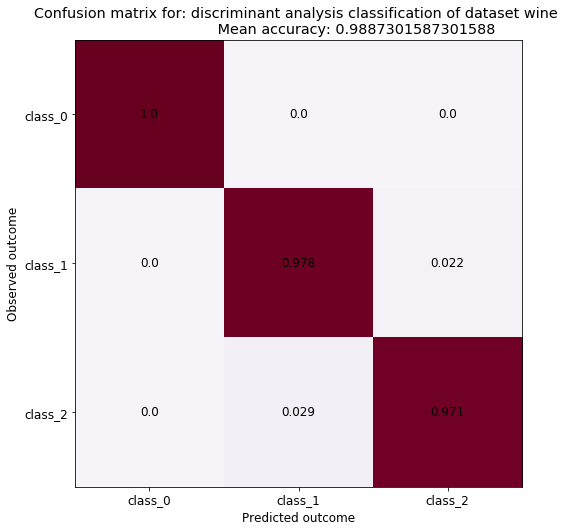

classifier:  knn , dataset:  breast_cancer , accuracy:  0.9595714951094549


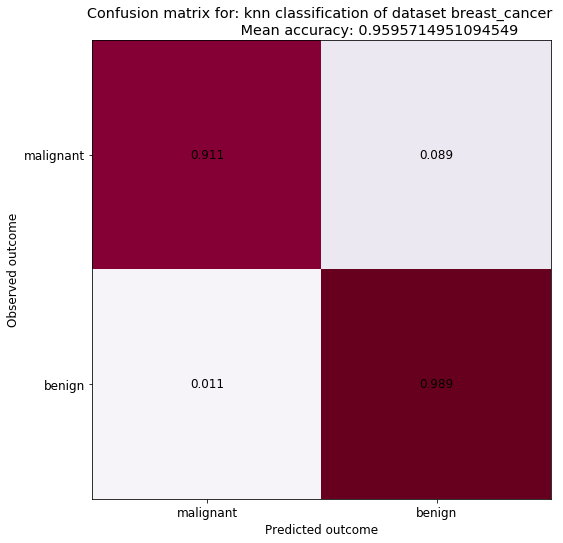

classifier:  logistic regression , dataset:  breast_cancer , accuracy:  0.9789163173420276


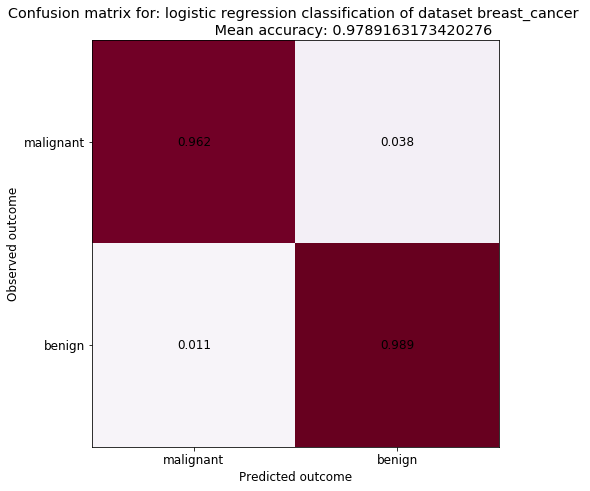

classifier:  decision tree , dataset:  breast_cancer , accuracy:  0.9261760596180716


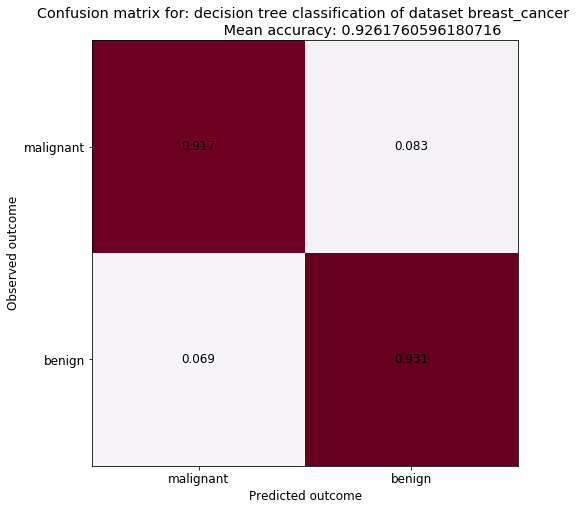

classifier:  discriminant analysis , dataset:  breast_cancer , accuracy:  0.9578481602235678


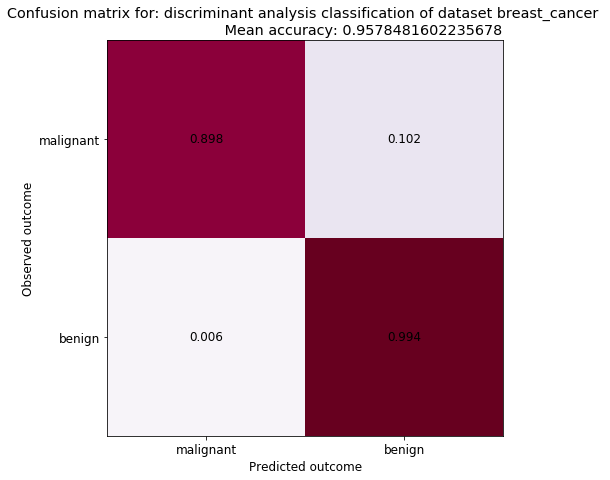

In [68]:
method_list = ['knn', 'logistic regression', 'decision tree', 'discriminant analysis']
data_sets = ['iris', 'digits', 'wine', 'breast_cancer'] 
for data in data_sets:
    for method in method_list:
        classifier = run_classifier(data, method, n_folds=5, confusion = True, k_neighbours=7)
        clsf = classifier[0]
        accuracy = classifier[1]
        